# Workflow design

## What is a workflow?

A workflow defines the phases (or steps) in a science project. Using a well-defined workflow is useful in that it provides a simple way to remind all team members (which includes a scheduler for instance) of the work to be done.

One way to think about the benefit of having a well-defined data workflow is that itsets guardrails to help you plan, organize, and implement your runs.

You have been using workflows before, for example with unix pipes:

In [1]:
# Linux machine
![ "$(uname)" = "Linux" ] && echo "number of physical cpus"  $(cat /proc/cpuinfo | grep "physical id" | uniq | wc -l)
![ "$(uname)" = "Linux" ] && echo "number of logical cores"  $(cat /proc/cpuinfo | grep "processor" | uniq | wc -l)
# Mac OS machine
![ "$(uname)" = "Darwin" ] && echo "number of physical cpus" $(sysctl -a | grep machdep.cpu.core_count | awk '{print $2}')
![ "$(uname)" = "Darwin" ] && echo "number of logical cores"  $(sysctl -a | grep machdep.cpu.thread_count| awk '{print $2}')

number of physical cpus 4
number of logical cores 4


In [2]:
def render_dot(dotscript: str, *args) -> str:
    """ render diagram with dot """
    from IPython.display import SVG
    import subprocess

    output = subprocess.check_output(('dot', '-Tsvg', *args),
                                     input=dotscript.encode())
    try:
        return SVG(data=output.decode())
    except Exception as e:
        print(output.decode())
        raise e


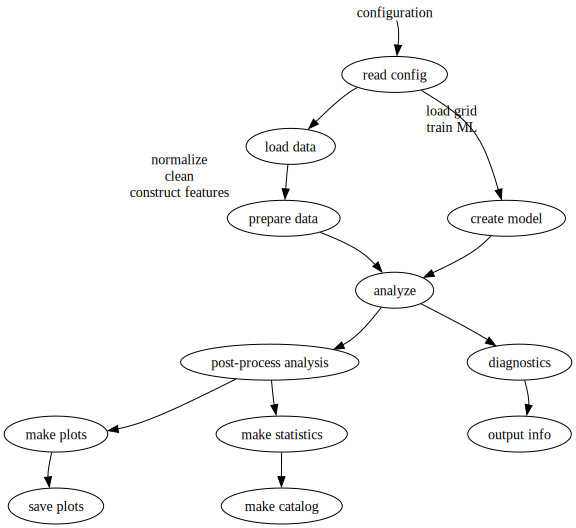

In [3]:
render_dot("""
digraph {
    rankdir=UD;
    splines=curved;
    nodesep=1.5;

    configuration [shape=plain]
    "read config"
    configuration ->  "read config"
    "read config" -> "load data" -> "prepare data"
    "prepare data" [xlabel="normalize\nclean\nconstruct features"]
    "read config" -> "create model" [xlabel="load grid\ntrain ML"]

    "create model" -> analyze
    "prepare data" -> analyze

    pproc [label="post-process analysis"]
    analyze -> pproc
    analyze -> diagnostics

    diagnostics -> "output info"
    pproc -> "make plots" -> "save plots"
    pproc -> "make statistics" -> "make catalog"
}
""")

You could rapidly see which parts could be parallelized. In addition, one could imagine analyzing a lot of independent chunks of data.

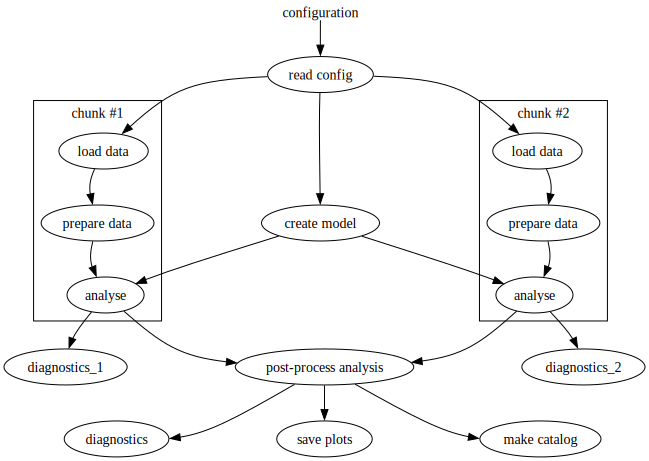

In [4]:
render_dot("""
digraph {
    rankdir=UD;
    splines=curved;
    nodesep=1.5;

    configuration [shape=plain]
    "read config"
    configuration ->  "read config"
    "read config" -> "create model"
    "create model" -> analyze_1
    "create model" -> analyze_2
    "read config" -> loaddata_1
    "read config" -> loaddata_2

    subgraph cluster_1 {
        label = "chunk #1";
        loaddata_1 [label="load data"]
        prepdata_1 [label="prepare data"]
        analyze_1 [label="analyse"]
        loaddata_1 -> prepdata_1
        prepdata_1 -> analyze_1
    }

    subgraph cluster_2 {
        label = "chunk #2";
        loaddata_2 [label="load data"]
        prepdata_2 [label="prepare data"]
        analyze_2 [label="analyse"]
        loaddata_2 -> prepdata_2
        prepdata_2 -> analyze_2
    }

    pproc [label="post-process analysis"]
    analyze_1 -> pproc -> diagnostics
    analyze_1 -> diagnostics_1
    analyze_2 -> pproc
    analyze_2 -> diagnostics_2


    pproc -> "save plots"
    pproc -> "make catalog"

}
""")

But you do not want to restart any of this from scratch.

What about having a flow that would be something like
```
download data -> checkpoint -> Analyze chunk = {C1 -> checkpoint, C2 -> checkpoint} -> post processing
```
where your code would know automatically that if the result of C1 did not change, there is not need to redo.

## Make

[Gnu Make](https://www.gnu.org/software/make/) is a / "the" tool of reference which controls the generation of executables and other non-source files of a program from the program's source files.

Make gets its knowledge of how to build your program from a file called the makefile, which lists each of the non-source files and how to compute it from other files. When you write a program, you should write a makefile for it, so that it is possible to use Make to build and install the program. 

Of course, even if initially meant to construct executables, we (users) have (trivially) extended the use-cases to generating anything.

```{important} 
Need to complete this section!
```

Makefiles define rules to "compile" parts of large programs. In the times of C/C++, one would have to compile source codes of many files and then link them. Make would detect which source files changed to recompile only the necessary parts. Other languages typically have their own tools that serve a similar purpose as Make. Make can also follow series of instructions to run depending on what files have changed (e.g. TeX documents). 

In [12]:
%%file Makefile

hello:
	echo "Hello World"

Overwriting Makefile


In [13]:
!make hello

echo "Hello World"
Hello World


````{warning}

```bash 
Makefile:3: *** missing separator.  Stop.
```

Makefiles must use <TABS> for block indentation.
````

### Makefile Syntax
A Makefile consists of a set of rules. A rule generally looks like this:

```makefile
targets: prerequisites
	command
	command
	command
```
`targets` corresponds to the name of a target file, and `prerequisites` is a list of target filenames separated by spaces. 
The `commands` are a series of steps or instructions typically creating the target file(s) and that depend on the prerequisites, i.e. dependencies. 
If the target files does not exist, the commands will run. If the files exist the rule will run only if the timestep of the target is older than any of the dependencies.

In [14]:
!touch hello
!make hello

make: 'hello' is up to date.


In the previous example, we created a `hello` file and thus the rule did not run.

### Example of C project

To understand better the relationship between targets and dependencies, let's look at a C example.

In [26]:
%%file hello.c
// hello.c - example from workflow chapter.
#include <stdio.h>
int main() { printf("Hello, World!"); return 0; }

Overwriting hello.c


In [27]:
%%file Makefile

hello: hello.c
	cc hello.c -o hello

Overwriting Makefile


In [28]:
!make hello && ./hello

cc hello.c -o hello
Hello, World!

When we run `make hello`, Make checks that the source `hello.c` is more recent than the target executable `hello` and runs the command if needed. Similarly if the latter does not exists. The timestamp comparison is the essence of make, i.e. identify that the source files are newer than the target executable. Conversely, it avoids redoing unecessary targets.

To make this happen, it uses the filesystem timestamps as a proxy to determine if something has changed. This is a reasonable heuristic, because file timestamps typically will only change if the files are modified.

In [29]:
! make hello

make: 'hello' is up to date.


In [30]:
! touch hello.c && make

cc hello.c -o hello


In the following, we create a Makefile that does all the steps from creating the source file, the object file and then the executable.

In [32]:
%%file Makefile

hello: hello.o
	cc hello.o -o hello # Runs third

hello.o: hello.c
	cc -c hello.c -o hello.o # Runs second

# Typically blah.c would already exist, but I want to limit any additional required files
hello.c:
	echo "#include <stdio.h>" > hello.c # runs first
	echo "int main() { printf("Hello, World!"); return 0; }" >> hello.c

Overwriting Makefile


In [33]:
!make hello

cc -c hello.c -o hello.o # Runs second
cc hello.o -o hello # Runs third


The Makefile ultimately runs all three targets. If one file is missing, the chain of rules will start from there.

### Clean target

`clean` is a common target used to remove the output of other targets, but it is not a special word in Make. You can run make and make clean on this to create and delete some_file.

### Default target

One can run `make` without any target rule. In this case, the default target will be created, i.e., the first rule in order from top to bottom in your Makefile.

### Variables

Makefiles can be complex and use variables. These can only be strings defined with `:=` (sometimes `=`, see later) 

In [43]:
%%file Makefile
files := file1 file2

test_variable: $(files)
	echo "Look at this variable: " $(files)

file1:
	touch file1
file2:
	touch file2


Overwriting Makefile


In [44]:
!make

echo "Look at this variable: " file1 file2
Look at this variable:  file1 file2


### the `all` target

Often you will find you want to create multiple targets. You can use the default target for that and by convension the first rule is called `all`.

```makefile
all: one two three

one:
	touch one
two:
	touch two
three:
	touch three
```


In [25]:
# cleaning files
import shutil, os
from glob import glob
for f in ['hello.c', 'hello', 'Makefile', 'file1', 'file2']:
    if os.path.isdir(f):
        shutil.rmtree(f)

## Snakemake ("*the pythonic make*")

[Snakemake](https://snakemake.readthedocs.io/en/stable/) is workflow management system, i.e. it is a tool to create reproducible and scalable data analyses. Workflows are described via a human readable, Python based language. They can be seamlessly scaled to server, cluster, grid and cloud environments, without the need to modify the workflow definition. Finally, Snakemake workflows can entail a description of required software, which will be automatically deployed to any execution environment.

In [ ]:
# Cleaning previous runs
import shutil, os
from glob import glob
for f in glob('*.done') + ['report', 'testdir', 'testdir1']:
    if os.path.isdir(f):
        shutil.rmtree(f)

In [ ]:
%%file snakefile

samples = [1, 2, 3, 4, 5]


rule all:
        input: "final.done", "rule11.done", "rule10.done"

rule a:
    output:
        "testdir/{sample}.out"
    group: "grp_a"
    shell:
        "touch {output}"

rule b:
    input:
        "testdir/{sample}.out"
    output:
        "testdir1/{sample}.out"
    group: "grp_a"
    shell:
        "touch {output}"

rule c:
    input:
        expand("testdir1/{sample}.out", sample=samples)
    output:
        "final.done"
    shell:
        "touch {output}"

rule rule10:
        output:
                "rule10.done"
        shell:
                "ls -la {input} > rule10.done"

rule rule2:
        input: "rule10.done", "rule11.done", "testdir"
        output: "rule2.done"
        shell: "touch rule2.done"

rule rule21:
        input: "rule10.done", "rule11.done"
        output: "rule21.done"
        shell: "touch rule21.done"

rule rule11:
        output: "rule11.done"
        shell: "touch rule11.done"

Writing snakefile


Building DAG of jobs...


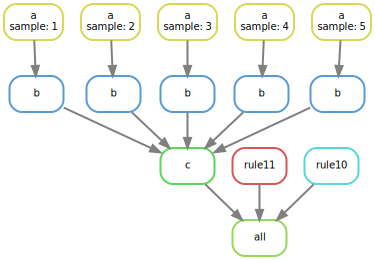

In [ ]:
from IPython.display import SVG
import subprocess

proc = subprocess.Popen(['snakemake',  '--dag'], stdout=subprocess.PIPE)
output = subprocess.check_output(('dot', '-Tsvg'), stdin=proc.stdout)
proc.wait()
SVG(data=output.decode())

In [ ]:
!snakemake -c1

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job       count    min threads    max threads
------  -------  -------------  -------------
a             5              1              1
all           1              1              1
b             5              1              1
c             1              1              1
rule10        1              1              1
rule11        1              1              1
total        14              1              1

Select jobs to execute...

[Mon May 22 22:15:45 2023]
rule a:
    output: testdir/4.out
    jobid: 9
    reason: Missing output files: testdir/4.out
    wildcards: sample=4
    resources: tmpdir=/var/folders/jb/twt_8kfx4mj86m9v8jgccs_r5gbl99/T

[Mon May 22 22:15:45 2023]
Finished job 9.
1 of 14 steps (7%) done
Select jobs to execute...

[Mon May 22 22:15:45 2023]
rule a:
    output: testdir/2.out
    jobid: 5
    reason:

### Running in parallel

Snakemake has even more to offer. In particular, it can run tasks in parallel. 

```text
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
```
The only change we need to make is call Snakemake with the `-j` or `-c` or `--core` argument to indicate the number of CPU cores available.

```bash
snakemake clean && snakemake -j 4
```

```text
Provided cores: 4
Rules claiming more threads will be scaled down.
...
```

The takeaway here is that all we need to do to scale from a serial pipeline is run `snakemake` with the `-j` option.

```{important}
Please note that just giving a Snakemake rule 4 threads does not automatically make its action run in parallel!  The action also needs to be capable to run in parallel.

snakemake as many powerful options, see `snakemake --help`
```

#### Managing CPUs per rule

Each rule has a number of optional keywords aside from the usual `input`, `output`, and `shell`/`run`.
The `threads` keyword is used to specify how many CPU cores a rule needs while executing.
Though in reality CPU and threads are not equivalent, snakemake does not (need to) make the difference.

In our previous example, we can for instance run rule `a` in parallel with 4 threads as

```python
rule a:
    output:
        "testdir/{sample}.out"
    group: "grp_a"
    threads: 4
    shell:
        "touch {output}"
```
(which does not change anything here as touch is not a parallel command.)


In [53]:
# Let's cleanup

!rm -rf testdir testdir1 snakefile final.done rule10.done rule11.done

### Snakemake with SLURM

Snakemake can submit each of your tasks to the slurm scheduler for you. 
You need to tell snakemake how jobs should be submitted to your HPC.

You have two options to provide that kind of information.

#### Option 1: Snakemake `--cluster`

You can provide the `--cluster` option to snakemake on the command line, and include all of the sbatch information you normally put at the top of your submission files.

```text
snakemake --cluster "sbatch -A CLUSTER_ACCOUNT -t CLUSTER_TIME -p CLUSTER_PARTITION -N CLUSTER_NODES" —jobs NUM_JOBS_TO_SUBMIT
```

The `--jobs` parameter allows snakemake to submit up to `NUM_JOBS_TO_SUBMIT` number of jobs. This is important to avoid running into the submission limits on your cluster (which is usually low). Snakemake will only submit jobs that can run (input files already exist). You can overide this behavior with `--immediate-submit`, but this could run into issues when jobs depend on each other and could start in the wrong sequence order from the scheduler queue.

#### Option 2: Snakemake `--cluster-config`

To save time you can also make a yaml file containing your sbatch information, and tell snakemake where to find it.
While still being possible, cluster configuration has been deprecated by the introduction of [Profiles](https://snakemake.readthedocs.io/en/stable/executing/cli.html#profiles).

We do not detail this option further as it will be removed in a future release.
Use the snakemake --cluster='sbatch ...' command.

#### Option 3: Snakemake `--profile`

We base this part on [smk-simple-slurm](https://github.com/jdblischak/smk-simple-slurm) to create a profile for a slurm cluster. 

```{important}
Parts of the code must be adapted to fit your SLURM platform
```

```{note}
[Snakemake-Profiles/slurm](https://github.com/Snakemake-Profiles/slurm) is another option but currently suffers from a bug which limits the number of jobs that can be submitted to the cluster.
```

1. We create a cluster profile for our work  in a `simple/` directory.

In [37]:
!mkdir simple/

mkdir: cannot create directory ‘simple/’: File exists


In [38]:
%%file simple/config.yaml

cluster:
  mkdir -p logs/{rule} &&
  sbatch
    --partition={resources.partition}
    --cpus-per-task={threads}
    --mem={resources.mem_mb}
    --job-name={resources.project}-{rule}-{wildcards}
    --output=logs/{rule}/{rule}-{wildcards}-%j.out
default-resources:
  - partition="debug"
  - mem_mb=1000
  - project="snakemake"
restart-times: 3
max-jobs-per-second: 10
max-status-checks-per-second: 1
local-cores: 1
latency-wait: 60
jobs: 500
keep-going: True
rerun-incomplete: True
printshellcmds: True
use-conda: True

Overwriting simple/config.yaml


Now we create some data to work with

In [50]:
!rm -rf input_data output 2>/dev/null
!mkdir input_data && touch input_data/sample{1..10}.txt

and define our workflow script

In [51]:
%%file snakefile
from glob import glob

n = len(glob("input_data/**txt"))


rule all:
    input:
        expand("output/sample{rep}.out", rep=range(1, n + 1)),


rule process:
    input:
        "input_data/sample{rep}.txt",
    output:
        "output/sample{rep}.out",
    shell:
        "touch {output}"

Writing snakefile


Let's check the work that needs to be done

In [52]:
!snakemake -n --quiet

Building DAG of jobs...
Job stats:
job        count    min threads    max threads
-------  -------  -------------  -------------
all            1              1              1
process       10              1              1
total         11              1              1



```{important}
note that the snakemake script is effectively a python code. In the example above we use glob to find all the input files.
```

Building DAG of jobs...


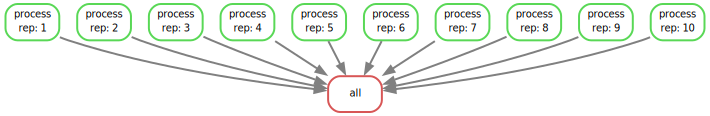

In [46]:
from IPython.display import SVG
import subprocess

proc = subprocess.Popen(['snakemake',  '--dag'], stdout=subprocess.PIPE)
output = subprocess.check_output(('dot', '-Tsvg'), stdin=proc.stdout)
proc.wait()
SVG(data=output.decode())

Finally you can run the project
```bash
snakemake --profile=simple/
```

```
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cluster nodes: 500
Job stats:
job        count    min threads    max threads
-------  -------  -------------  -------------
all            1              1              1
process      200              1              1
total        201              1              1

Select jobs to execute...

[Thu May 25 15:32:14 2023]
rule process:
    input: input_data/sample89.txt
    output: output/sample89.out
    jobid: 89
    reason: Missing output files: output/sample89.out
    wildcards: rep=89
    resources: mem_mb=1000, mem_mib=954, disk_mb=1000, disk_mib=954, tmpdir=<TBD>, partition=debug, project=snakemake

touch output/sample89.out
Submitted job 89 with external jobid 'Submitted batch job 1158585'.

[Thu May 25 15:32:15 2023]
rule process:
    input: input_data/sample75.txt
    output: output/sample75.out
    jobid: 75
    reason: Missing output files: output/sample75.out
    wildcards: rep=75
    resources: mem_mb=1000, mem_mib=954, disk_mb=1000, disk_mib=954, tmpdir=<TBD>, partition=debug, project=snakemake

touch output/sample75.out
Submitted job 75 with external jobid 'Submitted batch job 1158587'.

[Thu May 25 15:32:16 2023]
rule process:
    input: input_data/sample47.txt
    output: output/sample47.out
    jobid: 47
    reason: Missing output files: output/sample47.out
    wildcards: rep=47
    resources: mem_mb=1000, mem_mib=954, disk_mb=1000, disk_mib=954, tmpdir=<TBD>, partition=debug, project=snakemake

...
[Thu May 25 15:34:34 2023]
Finished job 89.
1 of 201 steps (0.5%) done
[Thu May 25 15:34:34 2023]
Finished job 75.
2 of 201 steps (1%) done
[Thu May 25 15:34:34 2023]
Finished job 47.
3 of 201 steps (1%) done
[Thu May 25 15:34:34 2023]
Finished job 33.
4 of 201 steps (2%) done
[Thu May 25 15:34:34 2023]
Finished job 117.
5 of 201 steps (2%) done
...
    ```

In [49]:
# cleanup
!rm -rf snakefile input_data output simple .snakemake

````{tip}
By default snakemake is an interactive command. It is more than recommended to run snakemake in a slurm job

```bash
#!/bin/bash
#
#SBATCH --job-name=snakemake_main_job
#SBATCH --ntasks=1
#SBATCH --nodes=1
#SBATCH --time=48:10:00
#SBATCH --mem-per-cpu=300M
#SBATCH --output=slurm_logs/%x-%j.log

mkdir -p slurm_logs
export SBATCH_DEFAULTS=" --output=slurm_logs/%x-%j.log"

module load anaconda3

date
srun snakemake --profile=simple
date
```

````

#### Adding Slurm resources to rules

For any rule, snakemake will understand various options to specify Slurm job submission and running conditions.

For examples counting words in one of our "books"

```python
rule count_words:
    input:
        wc='wordcount.py',
        book='books/{file}.txt'
    output: 'dats/{file}.dat'
    threads: 4
    resources: cpus=4, mem_mb=8000, time_min=20
    shell:
        '''
        python {input.wc} {input.book} {output}
        '''
```

### Migrating workflow `snakemake --archive`

Snakemake has a built-in method to archive all input files and scripts under version control: `snakemake --archive`. But there is more! It also installs any required dependencies if they can be installed using Anaconda’s conda package manager. You can use this feature to prepare your workflow on your laptop before migrating it to an HPC platform. 

For more information see [Snakemake deployment](http://snakemake.readthedocs.io/en/stable/snakefiles/deployment.html).


### Snakemake and using environment modules: `snakemake --use-envmodules`

In high performace cluster systems (HPC), it can be preferable to use environment modules for deployment of optimized versions of certain standard tools. Snakemake allows you to define modules needed per rule:

```python
rule bwa:
    input:
        "file1.in"
        "file2.in"
    output:
        "file3.out"
    envmodules:
        "jdk1.8.0_72",
    shell:
        "java -jar myjavacode.jar {input} {output}"
```

This rule requires `snakemake --use-envmodules` to load the listed modules in order.

```{note}
Modules are highly platform specific, and cannot be assumed to be available somewhere else, thereby limiting reproducibility. 
Instead prefer conda environment or container images (e.g., Docker).
```

### Running jobs in containers

As an alternative to using Conda environements and modules, it is possible to define a (docker) container to use even per rule, e.g.,

```python
rule makeplot:
    input:
        "data.txt"
    output:
        "plots/data_plot.pdf"
    container:
        "docker://jupyter/scipy-notebook"
    script:
        "scripts/plot-stuff.py"
```

When executing Snakemake with `snakemake --use-singularity`, it will execute the job within a container that is spawned from the given image. Allowed image urls entail everything supported by singularity (e.g., `shub://` and `docker://`). 
Other container runtimes will be supported in the future (e.g. podman).

A global definition of a container image can be given:

```python
container: "docker://jupyter/scipy-notebook"

rule NAME1:
    ...
```

In this case all jobs will be executed in that container. You can always override the image and even disable execution in container by setting the container directive of the rule to None (`container: None`).

### Using log files

Snakemake prints by default all output from `stderr` and `stdout` from the rules. This is useful but could be rapidly difficult to parse, especially when running in parallel.

The solution to this issue is to redirect the output from each rule to a dedicated log file with the `log` directive.  

```python
# count words in one of our "books"
rule NAME:
  input:
      codefile='mycode.py'
      file1='file1.in',
      file2='file2.txt'
  output: 'output/NAME.dat'
  threads: 4
  log: 'logs/NAME.log'
  shell:
      '''
      echo "Running {input.codefile} on {input.file1} {input.file2} with {threads} cores." &> {log}
      python {input.codefile} --njobs={threads} {input.file1} {input.file2} {output} &>> {log}
      '''
```

```{note}
`&>` redirects both `stdout` and `stderr` to a new file.
`&>>` is simliar to `&>`, but appends to the file instead of overwriting it.
```

```{important} 

`snakemake -n` 

Always run `snakemake -n` (dry-run) whenever you edit your Snakefile. This will check for errors and make sure that the pipeline is able to run.
The most common source of errors is a mismatch in filenames or a forgotten expansion. 
``` 

### Token files

It will happen that a rule does not generate a unique output or merely modifies a file (e.g. checking integrity, upload data etc). 
In these cases you can create a placeholder, aka _"token file"_ as output: an empty file that you create with the touch command as a dated proof of finished rule. An example rule using this technique is shown below:

```python
rule token_example:
    input:  'some_file.txt'
    output: 'token_example.done'   # marks some_file.txt as modified
    shell:
        '''
        some_command {input} && touch {output}
        '''
```

In [1]:
# clean up
!rm -rf Makefile hello* file[12]